In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import ppscore as pps
import statsmodels.api as sm
import matplotlib.pyplot as plt
import feature_engine
from datetime import timedelta
from datetime import datetime
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer
import math
import joblib
import pickle


In [45]:
excel_file_path = '../budgetusd.xlsx'
sheet_name = "Rooms Expenses"
df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
# Load the Excel file into a pandas DataFrame


In [46]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Set 'Date' as the index
df.set_index('Date', inplace=True)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['Rooms Cost'], axis=1),
                                        df['Rooms Cost'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)         



* Train set: (38, 2) (38,) 
* Test set: (10, 2) (10,)


In [48]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(RandomForestRegressor(random_state=101))),
        ("model", RandomForestRegressor(random_state=101)),
])

    return pipeline
pipeline_random_forest_reg()

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model', RandomForestRegressor(random_state=101))])

In [49]:
pipeline = pipeline_random_forest_reg()
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model', RandomForestRegressor(random_state=101))])

In [50]:
def feature_importance_tree_based_models(model, columns):
    """ Gets the mode, and the columns used to train the model
        we use the model.feature_importanes_ and columns to make a DataFrame that shows 
        the importance of each feature and then we print the features name and its relative 
        importance order, followed by a barplot indicating the importance
        """ 
    # Create DataFrame to display feature importance
    df_feature_importance = pd.DataFrame(data={
        'Features': columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    best_features = df_feature_importance['Features'].to_list()

    # Print the most important features and plot the feature importance
    print(f"* These are the {len(best_features)} most important features in descending order. The model was trained on them:")
    print(df_feature_importance['Features'].to_list())

    df_feature_importance.plot(kind='bar', x='Features', y='Importance')
    plt.show()

* These are the 1 most important features in descending order. The model was trained on them:
['Rooms Revenue']


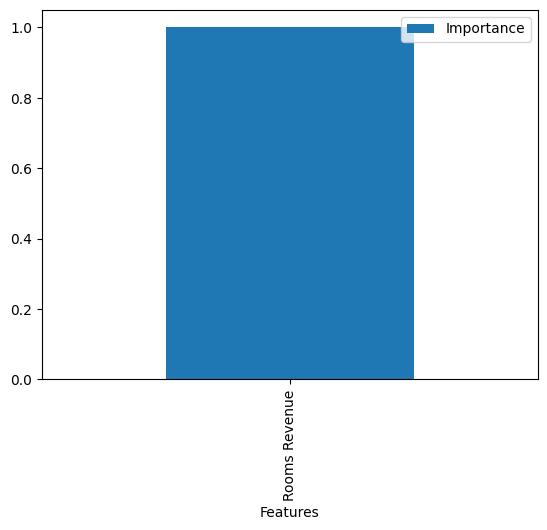

In [52]:
best_features = feature_importance_tree_based_models(model = pipeline['model'],
                                     columns = X_train.columns[pipeline['feature_selection'].get_support()])

In [55]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.89
Mean Absolute Error: 94.048
Mean Squared Error: 23918.061
Root Mean Squared Error: 154.655


* Test Set
R2 Score: 0.543
Mean Absolute Error: 194.812
Mean Squared Error: 86494.706
Root Mean Squared Error: 294.1




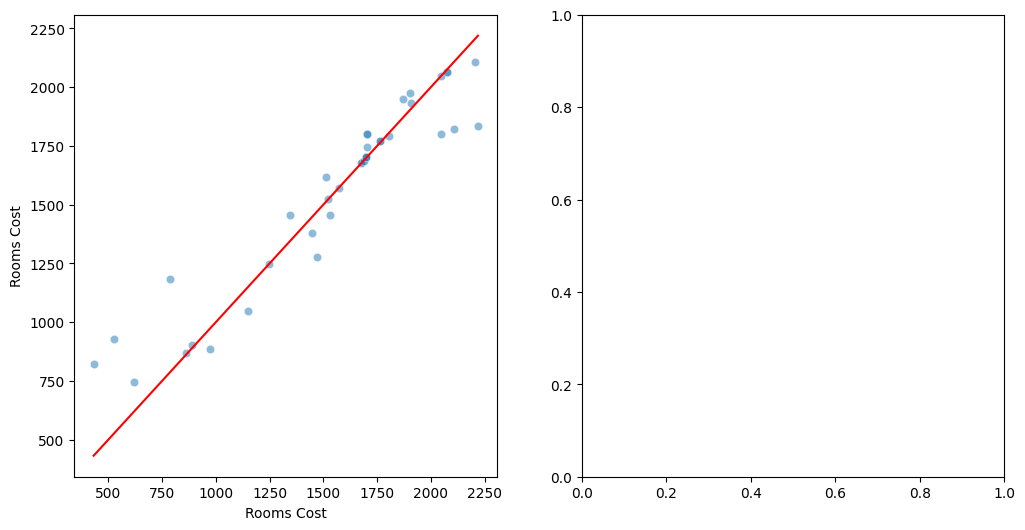

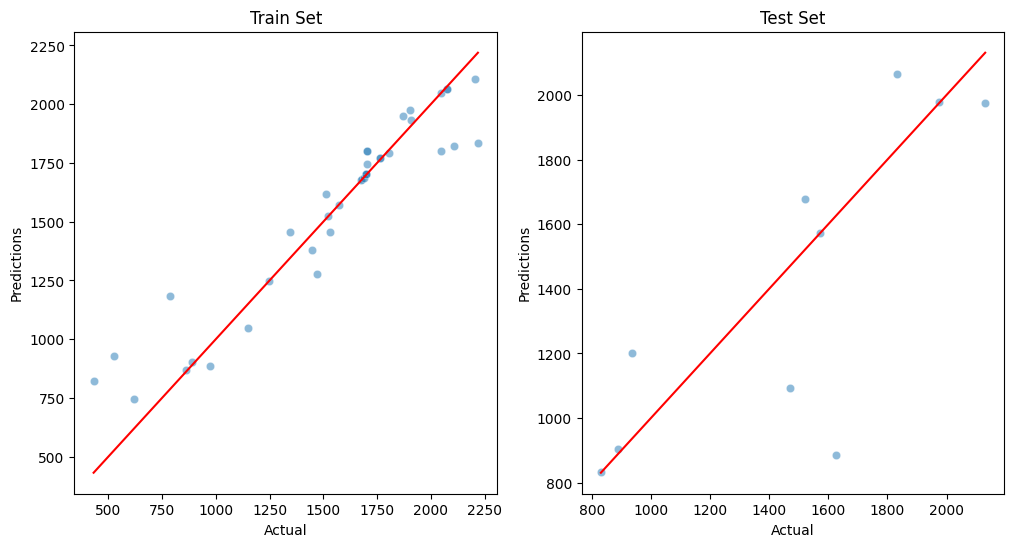

In [56]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5)

In [61]:
relevant_features = ['Rooms Revenue', 'Rooms Cost']
df_relevant = df[relevant_features]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df_relevant.drop(['Rooms Cost'], axis=1),
                                        df_relevant['Rooms Cost'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)         



* Train set: (38, 1) (38,) 
* Test set: (10, 1) (10,)


In [63]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
       
        ("model", RandomForestRegressor(random_state=101)),
])

    return pipeline
pipeline_random_forest_reg()

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=101))])

In [64]:
pipeline = pipeline_random_forest_reg()
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=101))])

In [65]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.89
Mean Absolute Error: 94.048
Mean Squared Error: 23918.061
Root Mean Squared Error: 154.655


* Test Set
R2 Score: 0.543
Mean Absolute Error: 194.812
Mean Squared Error: 86494.706
Root Mean Squared Error: 294.1




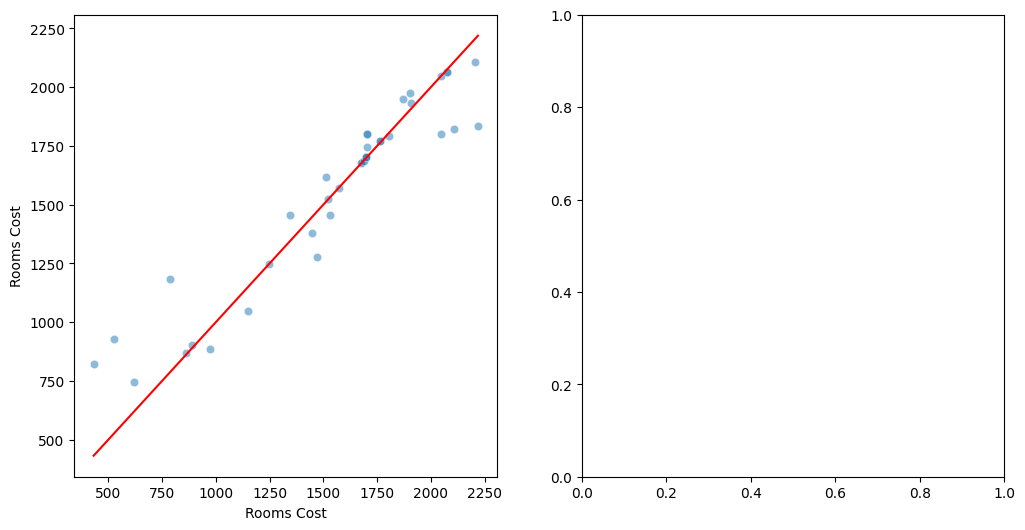

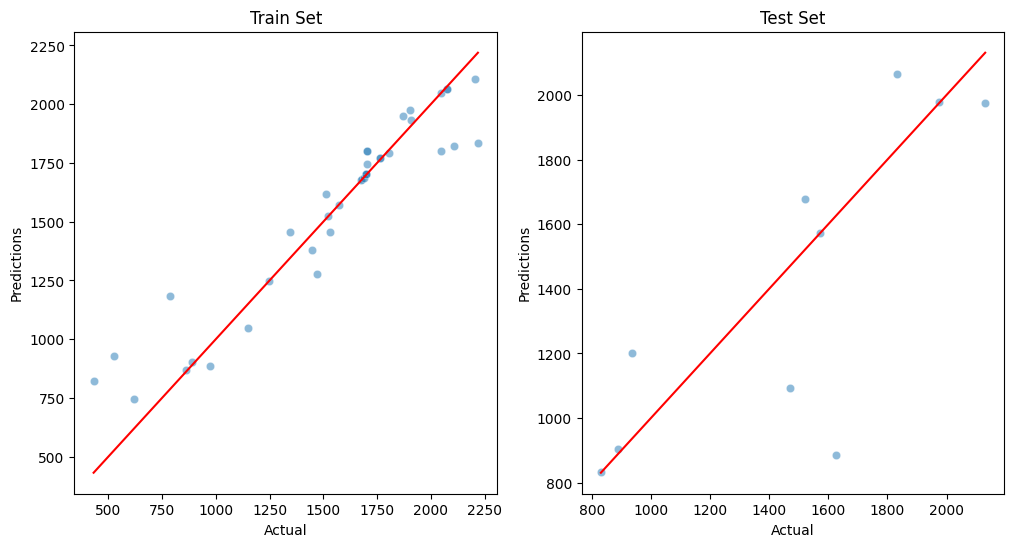

In [66]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5)

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have a DataFrame called 'df' with your data
X = df[['Rooms Revenue']]  # Independent variable
y = df['Rooms Cost']    # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# You can use the 'model' to make predictions on new data


Mean Squared Error: 46623.95365804194
R-squared: 0.7285429736540548


In [44]:
model_filename = 'rooms_expenses_model.pkl'
joblib.dump(model, model)

ValueError: Second argument should be a filename or a file-like object, LinearRegression() (type <class 'sklearn.linear_model._base.LinearRegression'>) was given.

In [41]:
import joblib

# Load the saved model from the file
model_filename = 'rooms_expenses_model.pkl'

try:
    loaded_model = joblib.load(model_filename)

    # Replace 'some_rooms_revenue_value' with the 'Rooms Revenue' value you want to predict 'Rooms Cost' for
    rooms_revenue_value = 13200  # Replace with the actual value

    # Create a list of lists with your 'Rooms Revenue' value(s)
    new_data = [[rooms_revenue_value]]

    # Use the loaded model to make predictions
    predicted_rooms_cost = loaded_model.predict(new_data)

    # Print the predicted 'Rooms Cost'
    print(f"Predicted Rooms Cost: {predicted_rooms_cost[0]}")
except FileNotFoundError:
    print(f"Model file '{model_filename}' not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


An error occurred: 'str' object has no attribute 'predict'
